# Benchmark of well-mixed stochastic solvers for a gene expression model

STEPS simulation of the Gene expression model described in appendix A.6 of https://link.springer.com/978-3-319-63113-4, comparing the performance of the 'direct' and 'rssa' stochastic solvers for this model. The solvers are also tested by comparing them to a simplified version of the model with an analytic solution.

## Model

The model consists of five species, $\{G,M,P,P_2,P_2G\}$, that interact as follows:

* A gene $G$ transcribes to an intermediate product $M$ with rate $c_1$.
* $M$ translates to a protein $P$ with rate $c_2$ or degrades with rate $c_3$.
* $P$ degrades with rate $c_4$, or two proteins $P$ can form a dimer $P_2$ with rate $c_5$, or vice versa with rate $c_6$.
* Finally the dimer $P_2$ can bind to $G$ with rate $c_7$, and vice versa with rate $c_8$.

This can be written as a set of eight reactions, each with a reaction rate $c_i$:
\begin{align}
    G &{\overset{c_1}{\rightarrow}} G + M \\
    M &{\overset{c_2}{\rightarrow}} M + P \\
    M &{\overset{c_3}{\rightarrow}} \emptyset \\
    P &{\overset{c_4}{\rightarrow}} \emptyset \\
    2 P &{\overset{c_5}{\rightarrow}} P_2 \\
    P_2 &{\overset{c_6}{\rightarrow}} 2 P \\
    P_2 + G &{\overset{c_7}{\rightarrow}} P_2 G \\
    P_2 G &{\overset{c_8}{\rightarrow}} P_2 + G \\
\end{align}

The initial condition of the model is to have $1000$ genes $G$, with the values for $c_i$ as specified below.

## STEPS setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np

We have reaction rates $c_i$ in units of $s^{-1}$, need to convert these to units of $M^{(1-n)}s^{-1}$ for the parameter `kcst` in STEPS, where $n$ is the order of the reaction, i.e. the number of molecules on the LHS:

In [2]:
def get_rate_conversion_factor(lhs_molecule_list, volume):
    import numpy as np

    # Avogadro number: molecules in 1 mol
    A = 6.02214076e23
    litres = 1e3 * volume
    # get order of reaction
    order = len(lhs_molecule_list)
    # get factorial factor
    counts = dict()
    factorial_factor = 1
    for lhs in lhs_molecule_list:
        counts[lhs] = counts.get(lhs, 0) + 1
        factorial_factor *= counts[lhs]
    return factorial_factor * np.power(A * litres, 1 - order)


# convert stochastic reaction rate in specified volume to STEPS kcst
def get_kcst(stoch_rate_c, lhs_molecule_list, volume):
    factor = get_rate_conversion_factor(lhs_molecule_list, volume)
    return stoch_rate_c / factor

In [3]:
import steps.model as smodel

mdl = smodel.Model()
vsys = smodel.Volsys('vsys', mdl)

molG = smodel.Spec('G', mdl)
molM = smodel.Spec('M', mdl)
molP = smodel.Spec('P', mdl)
molP2 = smodel.Spec('P2', mdl)
molP2G = smodel.Spec('P2G', mdl)

vol = 1e-20

kreac_1 = smodel.Reac(
    'kreac_1', vsys, lhs=[molG], rhs=[molG, molM], kcst=get_kcst(0.09, ['G'], vol)
)
kreac_2 = smodel.Reac(
    'kreac_2', vsys, lhs=[molM], rhs=[molM, molP], kcst=get_kcst(0.05, ['M'], vol)
)
kreac_3 = smodel.Reac(
    'kreac_3', vsys, lhs=[molM], rhs=[], kcst=get_kcst(0.001, ['M'], vol)
)
kreac_4 = smodel.Reac(
    'kreac_4', vsys, lhs=[molP], rhs=[], kcst=get_kcst(0.0009, ['P'], vol)
)
kreac_5 = smodel.Reac(
    'kreac_5',
    vsys,
    lhs=[molP, molP],
    rhs=[molP2],
    kcst=get_kcst(0.00001, ['P', 'P'], vol),
)
kreac_6 = smodel.Reac(
    'kreac_6', vsys, lhs=[molP2], rhs=[molP, molP], kcst=get_kcst(0.0005, ['P2'], vol)
)
kreac_7 = smodel.Reac(
    'kreac_7',
    vsys,
    lhs=[molP2, molG],
    rhs=[molP2G],
    kcst=get_kcst(0.005, ['P2', 'G'], vol),
)
kreac_8 = smodel.Reac(
    'kreac_8', vsys, lhs=[molP2G], rhs=[molP2, molG], kcst=get_kcst(0.9, ['P2G'], vol)
)

The geometry is a single well-mixed compartment:

In [4]:
import steps.geom as swm

wmgeom = swm.Geom()
comp = swm.Comp('comp', wmgeom)
comp.addVolsys('vsys')
comp.setVol(vol)

## Simulation

In [5]:
import steps.rng as srng
import steps.solver as ssolver

rng = srng.create('mt19937', 256)

solver_direct = ssolver.Wmdirect(mdl, wmgeom, rng)
solver_rssa = ssolver.Wmrssa(mdl, wmgeom, rng)

In [6]:
def simulate(
    solver,
    n_G=1000,
    t_final=100,
    t_interval=0.2,
    rng_seed=123,
    n_replicas=100,
    simplified_model=False,
):
    mol_list = ['G', 'M', 'P', 'P2', 'P2G']
    if simplified_model:
        mol_list = ['G', 'M', 'P']
    results = np.zeros((n_replicas, int(t_final / t_interval), int(1 + len(mol_list))))
    if solver.getSolverName() == "b'wmrk4'":
        n_replicas = 1
    for i in range(n_replicas):
        rng.initialize(rng_seed + i)
        solver.reset()
        solver.setCompCount('comp', 'G', n_G)
        if simplified_model:
            solver.setCompReacK('comp', 'kreac_5', 0)
            solver.setCompReacK('comp', 'kreac_6', 0)
            solver.setCompReacK('comp', 'kreac_7', 0)
            solver.setCompReacK('comp', 'kreac_8', 0)
        rep = []
        for t in np.arange(0.0, t_final, t_interval):
            solver.run(t)
            rep.append([t] + [solver.getCompCount('comp', mol) for mol in mol_list])
        results[i, :, :] = np.array(rep)
    return (np.mean(results, axis=0), np.std(results, axis=0) / np.sqrt(n_replicas))

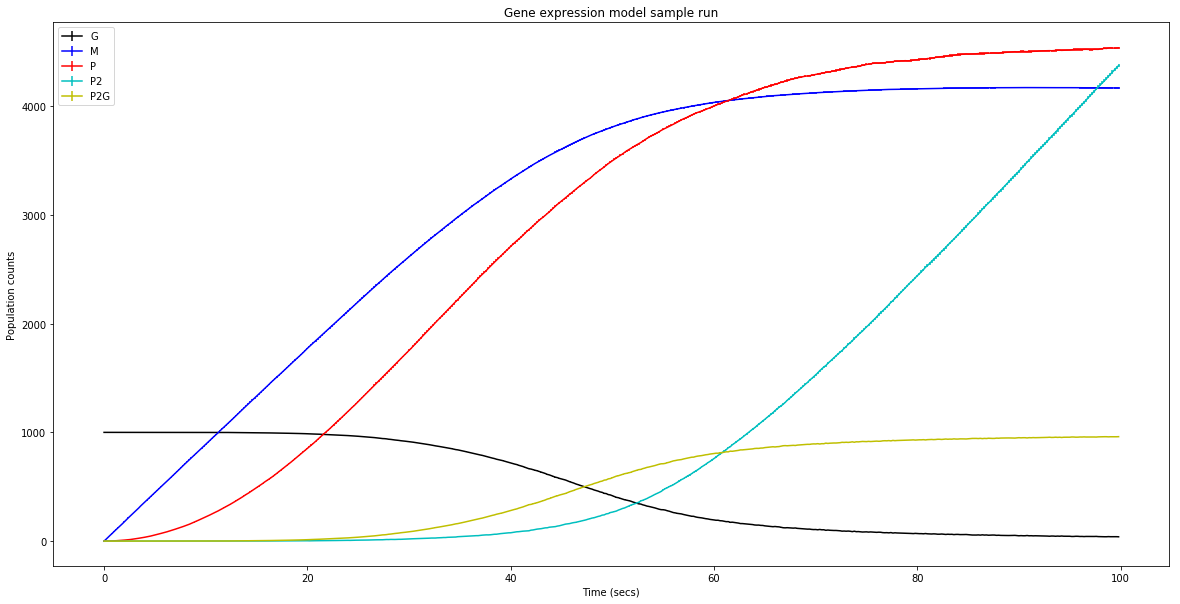

In [7]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.title("Gene expression model sample run")
(av, std) = simulate(solver_direct, t_final=100, n_replicas=50)
t = av[:, 0]
plt.errorbar(t, av[:, 1], yerr=std[:, 1], label='G', color='k')
plt.errorbar(t, av[:, 2], yerr=std[:, 2], label='M', color='b')
plt.errorbar(t, av[:, 3], yerr=std[:, 3], label='P', color='r')
plt.errorbar(t, av[:, 4], yerr=std[:, 4], label='P2', color='c')
plt.errorbar(t, av[:, 5], yerr=std[:, 5], label='P2G', color='y')
plt.xlabel("Time (secs)")
plt.ylabel("Population counts")
plt.legend()
plt.show()

## Benchmark

A comparison of the runtimes of the two stochastic solvers for this model.

In [8]:
def run_once(solver, n_G, t_final=100):
    solver.reset()
    solver.setCompCount('comp', 'G', n_G)
    solver.run(t_final)

def timing(solver, n_Gs = [10, 30, 100, 300, 1e3, 3e3, 1e4, 3e4, 1e5]):
    runtimes = []
    for n_G in n_Gs:
        reps = 3+int(5e4/n_G)
        timeit_output = %timeit -r $reps -n 1 -o run_once(solver, n_G=n_G);
        runtimes.append([n_G, timeit_output.best])
    return np.array(runtimes)

In [9]:
%%capture
runtime_rssa = timing(solver_rssa)
runtime_direct = timing(solver_direct)

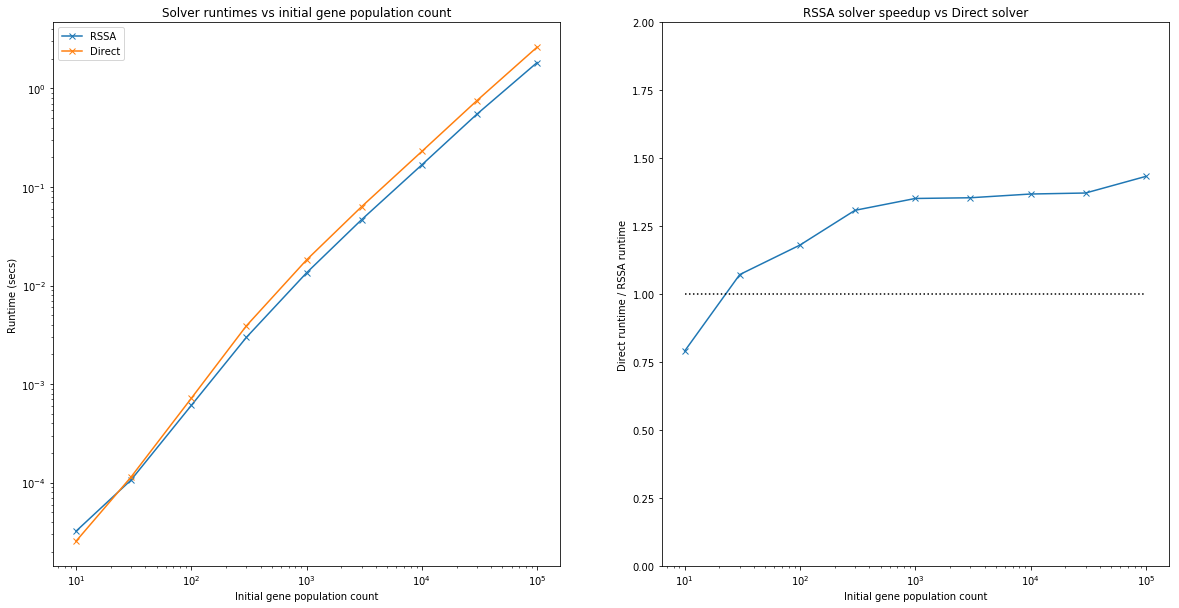

In [10]:
plt.subplot(1, 2, 1)
plt.title("Solver runtimes vs initial gene population count")
plt.plot(
    runtime_rssa[:, 0], runtime_rssa[:, 1], label="RSSA", marker="x", linestyle="-"
)
plt.plot(
    runtime_direct[:, 0],
    runtime_direct[:, 1],
    label="Direct",
    marker="x",
    linestyle="-",
)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Runtime (secs)")
plt.xlabel("Initial gene population count")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("RSSA solver speedup vs Direct solver")
plt.plot(
    runtime_rssa[:, 0],
    runtime_direct[:, 1] / runtime_rssa[:, 1],
    marker="x",
    linestyle="-",
)
plt.plot(
    runtime_rssa[:, 0],
    1.0 + 0 * runtime_rssa[:, 0],
    marker="",
    color="k",
    linestyle=":",
)
plt.xscale("log")
plt.ylim([0, 2])
plt.ylabel("Direct runtime / RSSA runtime")
plt.xlabel("Initial gene population count")

plt.show()

## Comparison with analytic solution for simplified model

As a simple check of the solvers, we can set $c_5-c_8$ to zero and solve the remaining differential equations analytically to give:

\begin{align}
G(t) &= G_0 \\
M(t) &= \frac{G_0 c_1}{c_3} (1 - e^{-c_3 t}) \\
P(t) &= \frac{G_0 c_1 c_2}{c_3 c_4} \left(1 + \frac{c_3 e^{-c_4 t} - c_4 e^{-c_3 t}}{c_4 - c_3} \right) \\
P_2(t) &= 0 \\
P_2G(t) &= 0 \\
\end{align}

In [11]:
def analytic_G(t, G0=1000):
    return 0.0 * t + G0


def analytic_M(t, G0=1000):
    c1 = kreac_1.getKcst()
    c3 = kreac_3.getKcst()
    return (G0 * c1 / c3) * (1.0 - np.exp(-c3 * t))


def analytic_P(t, G0=1000):
    c1 = kreac_1.getKcst()
    c2 = kreac_2.getKcst()
    c3 = kreac_3.getKcst()
    c4 = kreac_4.getKcst()
    ratio = 1.0 + (c3 * np.exp(-c4 * t) - c4 * np.exp(-c3 * t)) / (c4 - c3)
    return ratio * (G0 * c1 * c2) / (c3 * c4)

The three well-mixed solvers agree qualitatively with the analytic prediction:

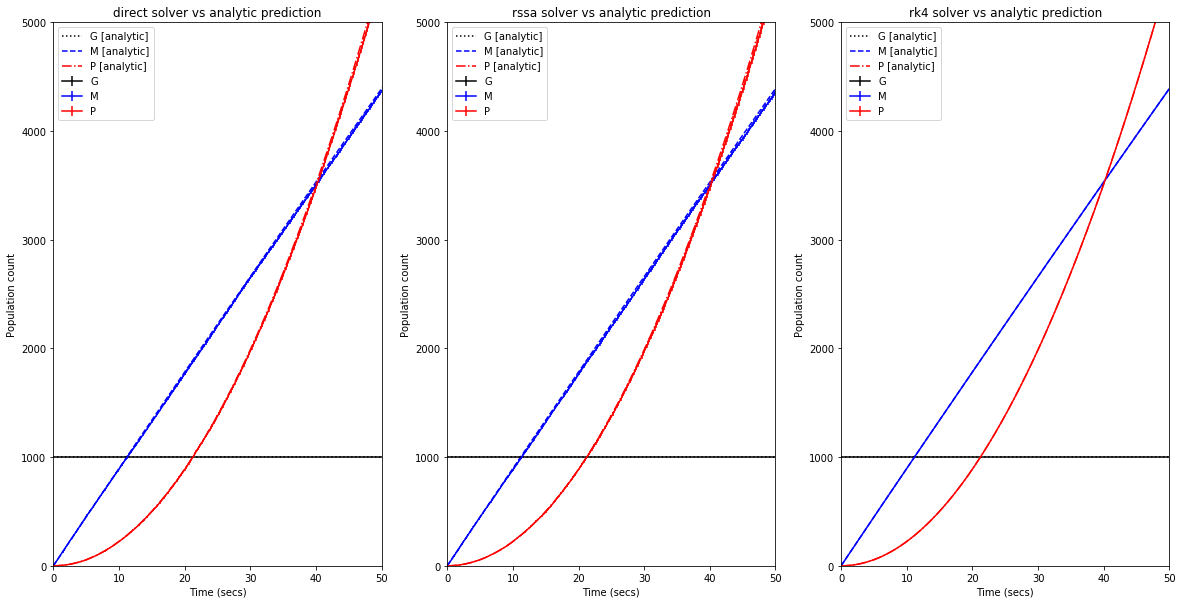

In [12]:
solver_rk4 = ssolver.Wmrk4(mdl, wmgeom)
solver_rk4.setRk4DT(1e-2)
solvers = [solver_direct, solver_rssa, solver_rk4]

for (i_solve, solver) in enumerate(solvers):
    plt.subplot(1, 3, i_solve + 1)
    plt.title("%s solver vs analytic prediction" % (str(solver.getSolverName())[4:-1]))
    (av, std) = simulate(solver, n_replicas=20, simplified_model=True)
    t = av[:, 0]
    plt.errorbar(t, av[:, 1], yerr=std[:, 1], label='G', color='k')
    plt.errorbar(t, av[:, 2], yerr=std[:, 2], label='M', color='b')
    plt.errorbar(t, av[:, 3], yerr=std[:, 3], label='P', color='r')
    plt.plot(t, analytic_G(t), label='G [analytic]', color='k', linestyle=':')
    plt.plot(t, analytic_M(t), label='M [analytic]', color='b', linestyle='--')
    plt.plot(t, analytic_P(t), label='P [analytic]', color='r', linestyle='-.')
    plt.xlim([0, 50])
    plt.ylim([0, 5000])
    plt.xlabel('Time (secs)')
    plt.ylabel('Population count')
    plt.legend()
plt.show()

A quantitative comparison of the difference between the numerical results and the analytic predicion with errorbars for the stochastic solvers:

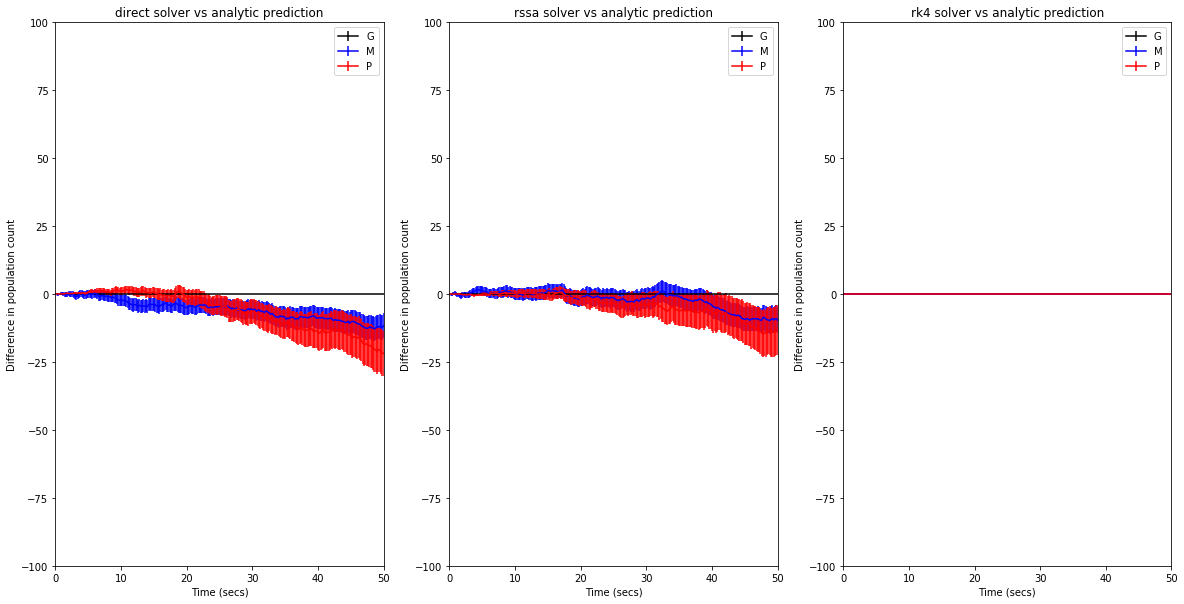

In [13]:
for (i_solve, solver) in enumerate(solvers):
    plt.subplot(1, 3, i_solve + 1)
    plt.title("%s solver vs analytic prediction" % (str(solver.getSolverName())[4:-1]))
    (av, std) = simulate(solver, n_replicas=200, simplified_model=True)
    t = av[:, 0]
    plt.errorbar(t, av[:, 1] - analytic_G(t), yerr=std[:, 1], label='G', color='k')
    plt.errorbar(t, av[:, 2] - analytic_M(t), yerr=std[:, 2], label='M', color='b')
    plt.errorbar(t, av[:, 3] - analytic_P(t), yerr=std[:, 3], label='P', color='r')
    plt.xlim([0, 50])
    plt.ylim([-100, 100])
    plt.xlabel('Time (secs)')
    plt.ylabel('Difference in population count')
    plt.legend()
plt.show()